In [1]:
import os
import librosa
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import BatchNormalization
from keras.utils import to_categorical

# Step 1: Load and preprocess the dataset

# Define the directory where your audio files are located
audio_directory = '/data/common_source/datasets/release_in_the_wild'

# Load the CSV file containing file, speaker, and label information
metadata_file = '/data/common_source/datasets/release_in_the_wild/meta.csv'
metadata_df = pd.read_csv(metadata_file)

# Initialize lists to store MFCCs and corresponding labels
X_mfccs = []
y_labels = []

# Define parameters for MFCC extraction
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
NUM_CLASSES = 2
N_MFCC = 13  # Number of MFCC coefficients
HOP_LENGTH = 512  # Hop length for MFCC extraction
WIN_LENGTH = 1024  # Window length for MFCC extraction
max_time_steps = 109  # Define the maximum time steps for your model

# Loop through each row in the metadata dataframe
for index, row in metadata_df.iterrows():
    file_path = os.path.join(audio_directory, row['file'])
    audio, sr = librosa.load(file_path, sr=None)
    
    # Extract MFCC features using librosa
    mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, n_fft=WIN_LENGTH)

    # Ensure all MFCC features have the same width (time steps)
    if mfcc.shape[1] < max_time_steps:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_time_steps - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_time_steps]
    
    X_mfccs.append(mfcc)
    y_labels.append(row['label'])

In [5]:
from sklearn.model_selection import train_test_split
from audiomentations import Compose, TimeStretch, PitchShift, AddGaussianNoise
import tensorflow as tf

# Data augmentation using audiomentations
augment = Compose([
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
])

X_augmented = [augment(samples=x, sample_rate=SAMPLE_RATE) for x in X_mfccs]

# Convert data to NumPy arrays
X_augmented = np.array(X_augmented)
y_labels = np.array(y_labels)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)
y_categorical = to_categorical(y_encoded)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_augmented, y_categorical, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2

# Define and compile a CNN model with L2 regularization and other improvements
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(N_MFCC, max_time_steps, 1),
           kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(np.expand_dims(X_train, -1), y_train, batch_size=32, epochs=30,
                    validation_data=(np.expand_dims(X_val, -1), y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(np.expand_dims(X_test, -1), y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save the trained model
model.save("gautham-model-new.h5")

Epoch 1/30


2023-10-15 11:27:35.362449: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


  1/795 [..............................] - ETA: 21:34 - loss: 36.4820 - accuracy: 0.4375

2023-10-15 11:27:35.854206: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-15 11:27:35.855114: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-15 11:27:35.855182: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-10-15 11:27:35.856112: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-15 11:27:35.856215: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


795/795 [==============================] - 7s 7ms/step - loss: 1.9759 - accuracy: 0.8368 - val_loss: 1.1277 - val_accuracy: 0.8820
Epoch 2/30
795/795 [==============================] - 5s 6ms/step - loss: 0.7659 - accuracy: 0.9181 - val_loss: 0.6028 - val_accuracy: 0.9116
Epoch 3/30
795/795 [==============================] - 5s 6ms/step - loss: 0.4696 - accuracy: 0.9345 - val_loss: 0.4956 - val_accuracy: 0.8974
Epoch 4/30
795/795 [==============================] - 5s 6ms/step - loss: 0.3463 - accuracy: 0.9406 - val_loss: 0.2788 - val_accuracy: 0.9541
Epoch 5/30
795/795 [==============================] - 5s 6ms/step - loss: 0.2727 - accuracy: 0.9492 - val_loss: 0.2503 - val_accuracy: 0.9490
Epoch 6/30
795/795 [==============================] - 5s 6ms/step - loss: 0.2385 - accuracy: 0.9525 - val_loss: 0.3821 - val_accuracy: 0.8958
Epoch 7/30
795/795 [==============================] - 5s 6ms/step - loss: 0.2347 - accuracy: 0.9473 - val_loss: 0.2355 - val_accuracy: 0.9484
Epoch 8/30
795/79

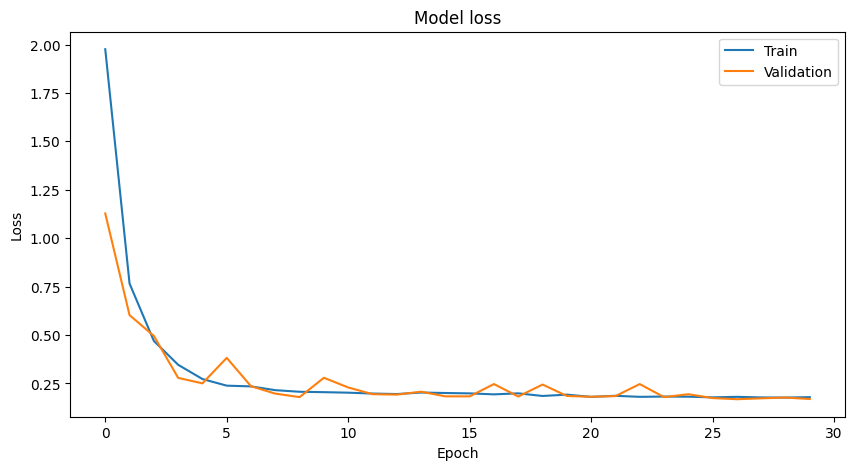

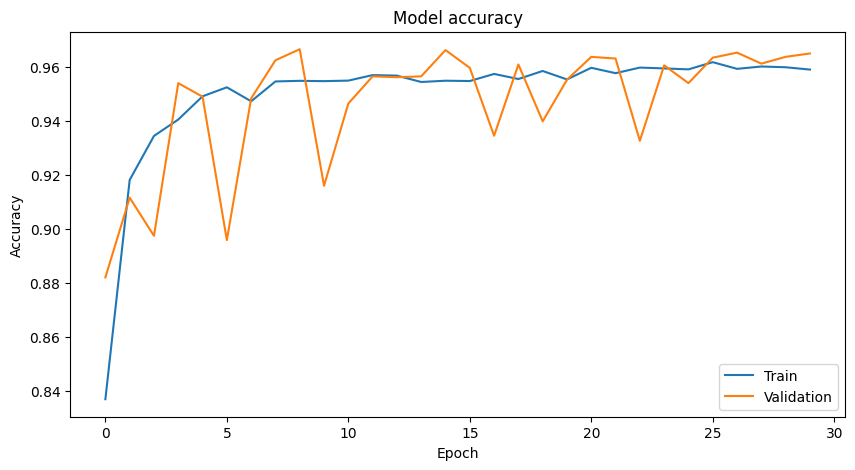

: 

In [7]:
# model.save('newtestmodel.h5')

import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()